# Reinforcement Learning Project - A Distributional Perspective on Reinforcement Learning

Sixtine Sphabmixay / Juliana Carvalho De Souza

In this file, we propose a very simple application of the C51 algorithm presented in our article, with an MDP with two states.

## 0. Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. C51 Experiment

In [ ]:
# Define the MDP

states = [0, 1]
actions = [0, 1]
transitions = {
    (0, 0): [0.8, 0.2],
    (0, 1): [0.3, 0.7],
    (1, 0): [0.5, 0.5],
    (1, 1): [0.9, 0.1],
}

rewards = {
    (0, 0): 1,
    (0, 1): 2,
    (1, 0): 3,
    (1, 1): 0,
}

gamma = 0.99

# C51 : Initialization
num_atoms = 51
v_min, v_max = 0, 300
delta_z = (v_max - v_min) / (num_atoms - 1)
z_atoms = np.linspace(v_min, v_max, num_atoms)


distributions = {
    (0, 0): np.ones(num_atoms) / num_atoms,
    (0, 1): np.ones(num_atoms) / num_atoms,
    (1, 0): np.ones(num_atoms) / num_atoms,
    (1, 1): np.ones(num_atoms) / num_atoms,
}


# Perform the Bellman update
def update_distribution_c51(s, a):
    """Perform a C51-style Bellman optimality update for Q(s,a)."""
    reward = rewards[(s, a)]
    next_state_probs = transitions[(s, a)]

    best_next_action_dists = []
    for next_s, prob_sprime in enumerate(next_state_probs):
        means_for_next_s = []
        for a_prime in actions:
            dist = distributions[(next_s, a_prime)]
            means_for_next_s.append(np.sum(dist * z_atoms))
        best_a_prime = np.argmax(means_for_next_s)
        best_dist = distributions[(next_s, best_a_prime)]
        best_next_action_dists.append((prob_sprime, best_dist))

    # Distributional Bellman Update
    new_dist = np.zeros(num_atoms)
    for prob_sprime, dist_best_next_a in best_next_action_dists:
        if prob_sprime == 0:
            continue
        v_proj = reward + gamma * z_atoms
        v_proj = np.clip(v_proj, v_min, v_max)
        b = (v_proj - v_min) / delta_z

        # Projection Step
        l = np.floor(b).astype(int)
        u = np.ceil(b).astype(int)
        for i in range(num_atoms):
            l_i = l[i]
            u_i = u[i]
            weight_l = (u[i] - b[i]) * prob_sprime
            weight_u = (b[i] - l[i]) * prob_sprime

            if 0 <= l_i < num_atoms:
                new_dist[l_i] += weight_l * dist_best_next_a[i]
            if 0 <= u_i < num_atoms:
                new_dist[u_i] += weight_u * dist_best_next_a[i]

    # Normalize
    dist_sum = new_dist.sum()
    if dist_sum > 0:
        return new_dist / dist_sum
    else:
        return np.ones(num_atoms) / num_atoms


# Run many iterations to (approximately) converge : vary the number of iterations to adjust
num_iterations = 300
for _ in range(num_iterations):
    # Update each (s,a) distribution in a loop
    for s in states:
        for a in actions:
            distributions[(s, a)] = update_distribution_c51(s, a)

mean_values = np.zeros((2, 2))
# Check final results (Compute the mean Q-values from the distributions)
for s in states:
    for a in actions:
        dist = distributions[(s, a)]
        mean_val = np.sum(dist * z_atoms)
        mean_values[s, a] = mean_val
        print(f"Mean Q-value for State {s}, Action {a}: {mean_val:.3f}")



Mean Q-value for State 0, Action 0: 254.832
Mean Q-value for State 0, Action 1: 256.250
Mean Q-value for State 1, Action 0: 257.094
Mean Q-value for State 1, Action 1: 253.771


## 2. Compare with the exact expected value function

In [12]:
# Initialize Q-values
Q = np.zeros((2, 2))

def V(s):
    return max(Q[s, 0], Q[s, 1])

for _ in range(1000):  # many iterations until stable
    # For s=0,a=0:
    Q00 = 1 + gamma * (0.8*V(0) + 0.2*V(1))
    # For s=0,a=1:
    Q01 = 2 + gamma * (0.3*V(0) + 0.7*V(1))
    # For s=1,a=0:
    Q10 = 3 + gamma * (0.5*V(0) + 0.5*V(1))
    # For s=1,a=1:
    Q11 = 0 + gamma * (0.9*V(0) + 0.1*V(1))

    Q[0,0], Q[0,1], Q[1,0], Q[1,1] = Q00, Q01, Q10, Q11

print("Final Q-values:")
print(" Q*(0,0) =", Q[0,0])
print(" Q*(0,1) =", Q[0,1])
print(" Q*(1,0) =", Q[1,0])
print(" Q*(1,1) =", Q[1,1])

Final Q-values:
 Q*(0,0) = 256.4220694644794
 Q*(0,1) = 257.8352581122257
 Q*(1,0) = 258.66998265312714
 Q*(1,1) = 255.33943173493014


# 3. Plot final Value Distributions


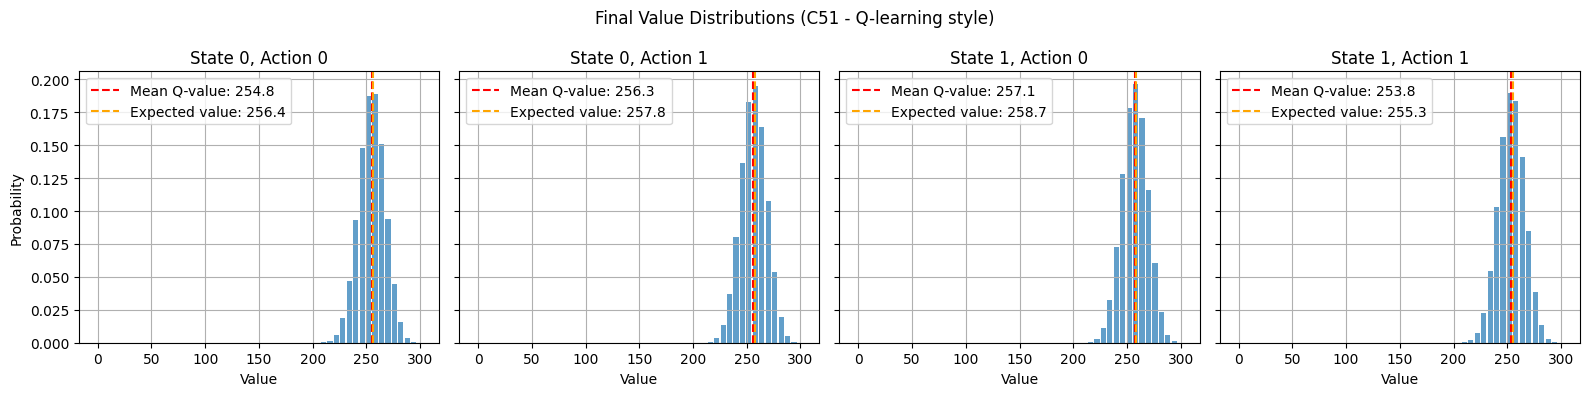

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
fig.suptitle("Final Value Distributions (C51 - Q-learning style)")

sa_pairs = [(0,0), (0,1), (1,0), (1,1)]
width = 0.8 * (z_atoms[1] - z_atoms[0])

for idx, (s, a) in enumerate(sa_pairs):
    dist = distributions[(s, a)]
    ax = axs[idx]
    ax.bar(z_atoms, dist, width=width, align="center", alpha=0.7)
    # add red line for Q-value
    ax.axvline(x=mean_values[s, a], color="red", linestyle="--", label=f"Mean Q-value: {mean_values[s, a]:.1f}")
    # a orange line for mean_values
    ax.axvline(x=Q[s, a], color="orange", linestyle="--", label="Expected value: {:.1f}".format(Q[s, a]))
    ax.legend()
    ax.set_title(f"State {s}, Action {a}")
    ax.set_xlabel("Value")
    if idx == 0:
        ax.set_ylabel("Probability")
    ax.grid(True)

plt.tight_layout()
plt.show()